# Cover Letter Generator

In today's competitive job market, submitting your resume often just isn't enough to make you stand out. Many companies now require a cover letter, but when you are applying to several jobs at once, writing an individual cover letter for each position can be time consuming. This project will solve this problem by creating a cover letter generator. 

The original goal was to use user information about the job listing and their experience extracted from a resume to create a unique cover letter for each job. Due to lack of training data, this generator can only generate generic cover letters with tokens that the user can fill in themselves.

Further work on this project is needed to accomplish the original goal, specifically more training data (sample cover letters) are needed. Despite not accomplishing the original goal, this model could still be useful by giving the user a starting point when writing cover letters if more training data was obtained.

In [1]:
#!pip install tensorflow
#!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk import word_tokenize

from transformers import BertTokenizer, TFBertModel, BertConfig

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import matplotlib.pyplot as plt

First I will define a function to checkout some of the corpus statistics.

In [3]:
def corpus_stats(corpus):
  print('Corpus Stats:')
  print('Number of Documents: ' + str(len(corpus.fileids())))
  print('Number of Paragraphs ' + str(len(corpus.paras())))
  print('Number of sentences: ' + str(len(corpus.sents())))
  print('Number of words: ' + str(len(corpus.words())))
  print("Vocabulary: " + str(len(set(w.lower() for w in corpus.words()))))
  print("Avg chars per word: " + str(round(len(corpus.raw())/len(corpus.words()),1)))
  print("Avg words per sentence: " + str(round(len(corpus.words())/len(corpus.sents()),1)))

Load the sample cover letter .txt files via NLTK's PlaintextCorpusReader.

In [4]:
path = './cover_letter_samples'
doc_pattern = r'.*\.txt'
corpus = PlaintextCorpusReader(path, doc_pattern)

In [5]:
corpus_stats(corpus)

Corpus Stats:
Number of Documents: 51
Number of Paragraphs 246
Number of sentences: 625
Number of words: 14942
Vocabulary: 2564
Avg chars per word: 5.6
Avg words per sentence: 23.9


In [6]:
docs = [corpus.raw(fileid) for fileid in corpus.fileids()]

Remove unwanted characters

In [7]:
docs = [doc.replace('\n', '') for doc in docs]
docs = [doc.replace('\r', '') for doc in docs]
docs = [doc.replace(')', '') for doc in docs]
docs = [doc.replace('(', '') for doc in docs]
docs = [doc.replace(',', '') for doc in docs]
docs = [doc.replace('.', '') for doc in docs]

In [8]:
docs = [doc.lower() for doc in docs]

Create a list of individual words for each document

In [9]:
tokenized = [word_tokenize(doc) for doc in docs]

lens = [len(token) for token in tokenized]

Make a single list of all documents

In [10]:
tokens_list = []
for token in tokenized:
    tokens_list.extend(token)

# Encoding

Now we will encode the text to numeric vectors using BERT encoder because it is pre-trained and can understand the meaning of words.

In [11]:
tz = BertTokenizer.from_pretrained("bert-base-cased")

In [12]:
encoded = tz.encode_plus(
    text=tokens_list,  # the text to be encoded
    add_special_tokens=True,  # Add [CLS] and [SEP]
    max_length = len(tokens_list),  # maximum length of a document
    truncation = True,
    padding = 'max_length',  # Add [PAD]s
    return_attention_mask = True,  # Generate the attention mask
    return_tensors = 'tf',  # ask the function to return TensorFlow tensors
)
input_ids = encoded['input_ids']
attn_mask = encoded['attention_mask']

The BERT encoder outputs a list of lists, so I will consolidate them into a single list

In [13]:
input_ids_list = []
for input_id in input_ids:
    input_ids_list.extend(input_id)

The BERT encoder also outputs tensors, I need to convert them to numpy arrays.

In [14]:
input_ids_int = []

for tensor in input_ids_list:
    input_ids_int.append(tensor.numpy())

Now that the words are numeric vectors, I will need to be able to decode the model's output. I will also need to be able to encode a test sample.

In [15]:
id_to_word = {input_ids_int[i]: tokens_list[i] for i in range(len(input_ids_int))}
word_to_id = {tokens_list[i]: input_ids_int[i] for i in range(len(tokens_list))}

We are modeling sequence-to-sequence, I will create sequences and the word that immediately follows that sequence to use as "labels."

In [16]:
seq_len = 5

In [17]:
X = []
y = []
for i in range(0, len(input_ids_list) - seq_len, 3):
    in_seq = input_ids_list[i:i+seq_len]
    out_seq = input_ids_list[i + seq_len]
    X.append(in_seq)
    y.append(out_seq)

Reshape the input to (*time steps*, *batch size*, *something else*) 

In [18]:
X_array = np.reshape(X, (len(X), seq_len, 1))

One-hot encode the labels

In [19]:
y_array = np_utils.to_categorical(y).T

In [20]:
y_array.shape

(27690, 4329)

# Modeling

In [21]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_array.shape[1], X_array.shape[2]), return_sequences=False))
model.add(Dense(y_array.shape[1], activation='softmax'))

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

I'm using ModelCheckpoint to save the model weights, so I don't have to retrain the model every time I restart the notebook.

In [23]:
history = model.fit(X_array, y_array, validation_split = 0.2, epochs=150, batch_size=256)

Epoch 1/150
14/14 [==============================] - 4s 158ms/step - loss: 8.3515 - val_loss: 2.0955
Epoch 2/150
14/14 [==============================] - 1s 93ms/step - loss: 7.4857 - val_loss: 2.2609
Epoch 3/150
14/14 [==============================] - 1s 93ms/step - loss: 6.7753 - val_loss: 2.4251
Epoch 4/150
14/14 [==============================] - 1s 93ms/step - loss: 8.0722 - val_loss: 2.5683
Epoch 5/150
14/14 [==============================] - 1s 95ms/step - loss: 7.6351 - val_loss: 2.6990
Epoch 6/150
14/14 [==============================] - 1s 99ms/step - loss: 6.3028 - val_loss: 2.7912
Epoch 7/150
14/14 [==============================] - 1s 100ms/step - loss: 6.5035 - val_loss: 2.8342
Epoch 8/150
14/14 [==============================] - 1s 96ms/step - loss: 8.1242 - val_loss: 2.9107
Epoch 9/150
14/14 [==============================] - 1s 96ms/step - loss: 8.5028 - val_loss: 2.9825
Epoch 10/150
14/14 [==============================] - 1s 102ms/step - loss: 7.9307 - val_loss: 3.0

14/14 [==============================] - 2s 114ms/step - loss: 5.6145 - val_loss: 4.3734
Epoch 82/150
14/14 [==============================] - 2s 117ms/step - loss: 5.5530 - val_loss: 4.3836
Epoch 83/150
14/14 [==============================] - 2s 112ms/step - loss: 8.2115 - val_loss: 4.3690
Epoch 84/150
14/14 [==============================] - 2s 115ms/step - loss: 6.3732 - val_loss: 4.4820
Epoch 85/150
14/14 [==============================] - 2s 113ms/step - loss: 7.5149 - val_loss: 4.3873
Epoch 86/150
14/14 [==============================] - 2s 118ms/step - loss: 7.1301 - val_loss: 4.4040
Epoch 87/150
14/14 [==============================] - 2s 114ms/step - loss: 5.7600 - val_loss: 4.5054
Epoch 88/150
14/14 [==============================] - 2s 116ms/step - loss: 5.7254 - val_loss: 4.5100
Epoch 89/150
14/14 [==============================] - 2s 117ms/step - loss: 5.5202 - val_loss: 4.6208
Epoch 90/150
14/14 [==============================] - 2s 116ms/step - loss: 7.2549 - val_loss: 

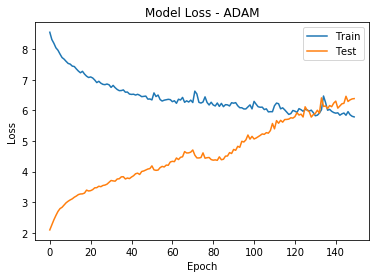

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss - ADAM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

This model is underfit, evidenced by the high test loss that doesn't converge. More training data might solve this problem. Because of the underfitting, the model will likely not output good results.

Now to test the model. I input the beginning of a cover letter. The loop deletes the first token in the sample, predicts on a sequence of the specified length, append the predicted word to the end of the sample. The first word is dropped and the model predicts on the next sequence. 

In [25]:
sample = "I would like to apply"
sample = sample.lower()
sample_split = word_tokenize(sample)
sample_split.insert(0, 0)

for i in range(25):
    sample_split = sample_split[1:]
    
    sample_ids = [word_to_id[word] for word in sample_split]

    sample_array = tf.convert_to_tensor(sample_ids)
    sample_array = [list(sample_array)]
    sample_array = np.reshape(sample_array, (1, seq_len, 1))
    prediction = model.predict(sample_array)


    pred_index = prediction[0].argmax()
    new_word = tokens_list[pred_index]
    sample_split.append(new_word)
    sample = sample + ' ' + new_word

sample = sample.capitalize()
print(sample)

I would like to apply would countries from i where 9 completed experience the would countries from i where 9 completed experience the would countries from i where 9 completed


# Model 2

This model is the same as model 1 except the optimzer is sigmoid gradient descent.

In [26]:
model_2 = Sequential()
model_2.add(LSTM(256, input_shape=(X_array.shape[1], X_array.shape[2])))
model_2.add(Dense(y_array.shape[1], activation='softmax'))

In [27]:
model_2.compile(loss='categorical_crossentropy', optimizer='SGD')

In [28]:
history_2 = model_2.fit(X_array, y_array, validation_split = 0.2, epochs=150, batch_size=256)

Epoch 1/150
14/14 [==============================] - 4s 144ms/step - loss: 7.5994 - val_loss: 1.9752
Epoch 2/150
14/14 [==============================] - 2s 114ms/step - loss: 9.2873 - val_loss: 1.9756
Epoch 3/150
14/14 [==============================] - 2s 115ms/step - loss: 6.7208 - val_loss: 1.9762
Epoch 4/150
14/14 [==============================] - 2s 115ms/step - loss: 7.2711 - val_loss: 1.9765
Epoch 5/150
14/14 [==============================] - 2s 112ms/step - loss: 9.4867 - val_loss: 1.9767
Epoch 6/150
14/14 [==============================] - 2s 113ms/step - loss: 8.2088 - val_loss: 1.9770
Epoch 7/150
14/14 [==============================] - 2s 110ms/step - loss: 6.6097 - val_loss: 1.9773
Epoch 8/150
14/14 [==============================] - 2s 117ms/step - loss: 7.4260 - val_loss: 1.9776
Epoch 9/150
14/14 [==============================] - 2s 111ms/step - loss: 8.4304 - val_loss: 1.9779
Epoch 10/150
14/14 [==============================] - 2s 114ms/step - loss: 12.5392 - val_l

14/14 [==============================] - ETA: 0s - loss: 7.965 - 2s 112ms/step - loss: 7.9918 - val_loss: 2.0033
Epoch 82/150
14/14 [==============================] - 2s 111ms/step - loss: 8.7273 - val_loss: 2.0036
Epoch 83/150
14/14 [==============================] - 1s 108ms/step - loss: 6.8384 - val_loss: 2.0040
Epoch 84/150
14/14 [==============================] - 1s 108ms/step - loss: 10.4531 - val_loss: 2.0043
Epoch 85/150
14/14 [==============================] - 1s 108ms/step - loss: 8.3330 - val_loss: 2.0047
Epoch 86/150
14/14 [==============================] - 1s 108ms/step - loss: 8.1347 - val_loss: 2.0051
Epoch 87/150
14/14 [==============================] - 2s 110ms/step - loss: 6.7960 - val_loss: 2.0054
Epoch 88/150
14/14 [==============================] - 2s 109ms/step - loss: 8.2062 - val_loss: 2.0057
Epoch 89/150
14/14 [==============================] - 1s 108ms/step - loss: 7.1955 - val_loss: 2.0060
Epoch 90/150
14/14 [==============================] - 2s 108ms/step - 

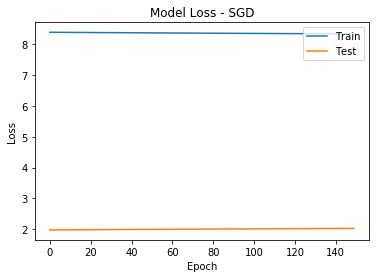

In [29]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss - SGD')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [30]:
sample = "I would like to apply"
sample = sample.lower()
sample_split = word_tokenize(sample)
sample_split.insert(0, 0)

for i in range(25):
    sample_split = sample_split[1:]

    sample_ids = [word_to_id[word] for word in sample_split]

    sample_array = tf.convert_to_tensor(sample_ids)
    sample_array = [list(sample_array)]
    sample_array = np.reshape(sample_array, (1, seq_len, 1))
    prediction = model_2.predict(sample_array)


    pred_index = prediction[0].argmax()
    new_word = tokens_list[pred_index]
    sample_split.append(new_word)
    sample = sample + ' ' + new_word

sample = sample.capitalize()
print(sample)

I would like to apply projects projects projects projects projects projects projects projects projects projects projects projects projects projects projects projects projects projects projects projects projects projects projects projects projects


The output of both of these models is English text, but it does not make sense. The first model (using ADAM optimizer) seems to be better as the loss of the training and test sets actually do see to approach convergence. The second model's loss never changes. Since both models have an underfitting problem, the results could probably be improved by more training data. Neural nets require large training sets, and my corpus only contains 51 cover letter samples.